In [1]:
import os
from nltk.tree import Tree
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk as nltk
import time

In [2]:
# Setup working directory and relative filepaths
current_dir = os.curdir
data_dir = os.path.join(current_dir, "data")
output_dir = os.path.join(current_dir, "data_clean")

# Get data path
abc_data_dir = os.path.join(data_dir, "abc-news.csv")
bbc_data_dir = os.path.join(data_dir, "bbc-news.csv")
cbs_data_dir = os.path.join(data_dir, "cbs-news.csv")
cnn_data_dir = os.path.join(data_dir, "cnn-news.csv")

# Read csv data
abc_data_csv = pd.read_csv(abc_data_dir, encoding="utf-16")
bbc_data_csv = pd.read_csv(bbc_data_dir, encoding="utf-16")
cbs_data_csv = pd.read_csv(cbs_data_dir, encoding="utf-16")
cnn_data_csv = pd.read_csv(cnn_data_dir, encoding="utf-16")

In [3]:
abc_data_df = pd.DataFrame(abc_data_csv.copy())
bbc_data_df = pd.DataFrame(bbc_data_csv.copy())
cbs_data_df = pd.DataFrame(cbs_data_csv.copy())
cnn_data_df = pd.DataFrame(cnn_data_csv.copy())

In [4]:
# Remove columns from Dataframe
col_ls = ['id', 'page_id', 'caption', 'picture']
abc_data_df.drop(columns = col_ls, inplace = True)
bbc_data_df.drop(columns = col_ls, inplace = True)
cbs_data_df.drop(columns = col_ls, inplace = True)
cnn_data_df.drop(columns = col_ls, inplace = True)

In [5]:
class CleanData:
    def __init__(self, df): # constructor for df
        self.df = df

    def show_df(self): # Show dateframe object when passed to CleanData
        return self.df
    
    def news_outlet(self, outlet=''): # append news outlet name to self.df as a new column

        self.df['news_outlet'] = outlet
        return self.df
    
    def numeric_category(self): # Determine how many post_types and status_types and factorize types, use method only on combined dataframe

        self.post_types_unique = pd.unique(self.df['post_type'])
        self.post_types_factorize = pd.factorize(self.post_types_unique, sort=True)[0]
        self.status_types_unique = pd.unique(self.df['status_type'])
        self.status_types_unique = [i for i in self.status_types_unique if str(i) != 'nan']
        self.status_types_factorize = pd.factorize(self.status_types_unique, sort=True)[0]

        self.post_types_dict = dict(zip(self.post_types_unique, self.post_types_factorize)) # Create dictionary for post_types and status_types
        self.status_types_dict = dict(zip(self.status_types_unique, self.status_types_factorize))
        
        def post_cat(x):
            for type, category in self.post_types_dict.items():
                if x in type:
                    return category

        def status_cat(x):
            for type, category in self.status_types_dict.items():
                if x in type:
                    return category
            
        self.df['post_category'] = self.df['post_type'].apply(post_cat)
        self.df['status_category'] = self.df['status_type'].apply(status_cat)

        return self.df

    def calculate_reacts(self): # Calculate reacts for self.df

        self.react_col = ['likes_count', 'comments_count', 'shares_count', 'love_count', # store columns of interest 
            'wow_count', 'haha_count', 'sad_count', 'thankful_count', 'angry_count',]
        self.df['total_reacts'] = self.df[self.react_col].sum(axis=1) # sum self.react_col by row

        return self.df

    def clean_datetime(self): # Clean datetime of self.df

        def round_hour(t):
            t_start_hr = t.replace(minute=0, second=0, microsecond=0) # round to down to nearest hour
            t = t_start_hr
            return t

        self.df['posted_at'] = pd.to_datetime(self.df['posted_at']) # change dtype to datetime
        self.df['posted_at'] = self.df['posted_at'].apply(round_hour) # apply round_hour
        self.df['date_posted'] = [date.date() for date in self.df['posted_at']] # store date() from datetime object
        self.df['time_posted'] = [time.time() for time in self.df['posted_at']] # store time() from datetime object
        self.df.drop(columns=['posted_at'], inplace=True)

        return self.df
    
    
    def analyze_df(self):

        def analyze_sentiment(headline):
            analysis = TextBlob(str(headline))
            return analysis.sentiment # returns sentiment, subjectivity

        self.df[['name_sentiment', 'name_subjectivity']] = np.array([analyze_sentiment(str(headline)) for headline in self.df['name']]) # store sentiment, subjectivity in new columns

        return self.df

    def fill_na(self):
        self.df['status_type'] = self.df['status_type'].fillna(self.df.mode().iloc[0][2]) # self.df.mode().iloc[0] returns a list of the most frequent values for each column in self.df iloc[0][2] accesses status_type
        return self.df
    
    def process_text(self):

        def clean_text(text):
            text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', str(text)) # remove links
            text = ''.join([char for char in str(text) if char not in string.punctuation]) # remove punction from string
            text = ''.join([char if ord(char) < 128 else '' for char in text]) # join character only if unicode value is less than 128
            text = re.sub('[0-9]+', '', text) # replace numbers with empty string
            return text
        
        self.df['name_processed'] = self.df['name'].apply(clean_text)
        self.df['message_processed'] = self.df['message'].apply(clean_text)
        self.df['description_processed'] = self.df['description'].apply(clean_text)

        return self.df
        
    def form_sentence(self, target_col=''):
        def sentence(words):
            words = ' '.join(word for word in words)
            return words

        self.df[target_col] = self.df[target_col].apply(sentence)

        return self.df

In [6]:
# ABC Data cleaning
abc_data_clean = CleanData(abc_data_df)
abc_data_clean.fill_na()
abc_data_clean.news_outlet(outlet='ABC')
abc_data_clean.calculate_reacts()
abc_data_clean.clean_datetime()
abc_data_clean.analyze_df()
abc_data_clean = abc_data_clean.show_df()

In [7]:
# BBC Data cleaning
bbc_data_clean = CleanData(bbc_data_df)
bbc_data_clean.fill_na()
bbc_data_clean.news_outlet(outlet='BBC')
bbc_data_clean.calculate_reacts()
bbc_data_clean.clean_datetime()
bbc_data_clean.analyze_df()
bbc_data_clean = bbc_data_clean.show_df()

In [8]:
# CBS Data cleaning
cbs_data_clean = CleanData(cbs_data_df)
cbs_data_clean.fill_na()
cbs_data_clean.news_outlet(outlet='CBS')
cbs_data_clean.calculate_reacts()
cbs_data_clean.clean_datetime()
cbs_data_clean.analyze_df()
cbs_data_clean = cbs_data_clean.show_df()

In [9]:
# CNN Data cleaning
cnn_data_clean = CleanData(cnn_data_df)
cnn_data_clean.fill_na()
cnn_data_clean.news_outlet(outlet='CNN')
cnn_data_clean.calculate_reacts()
cnn_data_clean.clean_datetime()
cnn_data_clean.analyze_df()
cnn_data_clean = cnn_data_clean.show_df()

In [10]:
# Combine news outlet and store in new dataframe
news_data_combined_df = pd.concat([abc_data_clean, bbc_data_clean, cbs_data_clean, cnn_data_clean])
news_data_combined_clean = CleanData(news_data_combined_df)
news_data_combined_clean.process_text()
news_data_combined_clean = news_data_combined_clean.show_df()

In [11]:
# Melt columns 
news_data_text_pivot = news_data_combined_clean[['name_processed','message_processed', 'description_processed','news_outlet']].copy() # create a copy of df 
news_data_text_pivot['news_outlet'] = news_data_text_pivot['news_outlet'].str.cat(map(str, news_data_text_pivot.index), sep='_') # add incrementing int to end of string
news_data_text_pivot = news_data_text_pivot.rename(columns={'name_processed':'A1','message_processed':'A2', 'description_processed':'A3'}) # rename columns before pivot .wide_to_long
news_data_text_pivot = pd.wide_to_long(news_data_text_pivot, stubnames=['A'], i=['news_outlet'], j='drop').reset_index().drop('drop', 1) # combining name, message, description to one column      
news_headlines = news_data_text_pivot[news_data_text_pivot['A'].str.contains('nan')==False] # remove rows containing 'nan'

In [12]:
# Remove nan and empty rows
news_headlines = news_headlines.copy()
news_headlines['A'] = news_headlines['A'].replace(r'^\s*$', np.nan, regex=True) # Replace empty rows containing only whitespace 
news_headlines = news_headlines.dropna(axis=0, how='any')


In [13]:
# Tokenize
def tokenize_text(text):  
    text_token = TextBlob(text)
    return text_token.words
news_headlines['A'] = news_headlines['A'].apply(tokenize_text) 

In [14]:
# Define method to remove stopwords using nltk stopwords
stop_words = stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stop_words]
    return text
news_headlines['A'] = news_headlines['A'].apply(remove_stopwords)
print(news_headlines)

       news_outlet                                                  A
0            ABC_0  [Chief, Justice, Roberts, Responds, Judicial, ...
1            ABC_1  [With, Reservations, Obama, Signs, Act, Allow,...
2            ABC_2                 [Wishes, For, Fall, Times, Square]
3            ABC_3  [Mitt, Romney, Vows, Veto, Dream, Act, President]
4            ABC_4  [NY, Pharmacy, Shootout, Leaves, Suspect, ATF,...
...            ...                                                ...
393474   CNN_31630  [There, members, Wellesley, Women, Hillary, gr...
393475   CNN_31631  [Kids, picked, Hillary, Clinton, president, on...
393516   CNN_31672  [Before, pull, lever, Election, Day, know, sta...
393519   CNN_31675  [You, wont, recognize, name, face, youve, defi...
393532   CNN_31688  [If, Trump, wins, move, Canada, says, cape, Br...

[295604 rows x 2 columns]


In [15]:
# Join tokenized text to form sentence
news_headlines = CleanData(news_headlines.copy())
news_headlines.form_sentence(target_col='A')
news_headlines = news_headlines.show_df()
print(news_headlines)

       news_outlet                                                  A
0            ABC_0  Chief Justice Roberts Responds Judicial Ethics...
1            ABC_1  With Reservations Obama Signs Act Allow Detent...
2            ABC_2                       Wishes For Fall Times Square
3            ABC_3          Mitt Romney Vows Veto Dream Act President
4            ABC_4  NY Pharmacy Shootout Leaves Suspect ATF Agent ...
...            ...                                                ...
393474   CNN_31630  There members Wellesley Women Hillary group Wh...
393475   CNN_31631  Kids picked Hillary Clinton president online N...
393516   CNN_31672  Before pull lever Election Day know states don...
393519   CNN_31675  You wont recognize name face youve definitely ...
393532   CNN_31688  If Trump wins move Canada says cape Breton island

[295604 rows x 2 columns]


In [16]:
# Split news_outlet into news_outlet and outlet_id
news_headlines[['news_outlet', 'outlet_id']] = news_headlines['news_outlet'].str.split('_', expand=True)

In [17]:
# Sentiment Analysis
news_headlines.rename(columns={'A' : 'name'}, inplace=True)
news_headlines = CleanData(news_headlines)  
news_headlines.analyze_df()
news_headlines = news_headlines.show_df()
print(news_headlines)

       news_outlet                                               name  \
0              ABC  Chief Justice Roberts Responds Judicial Ethics...   
1              ABC  With Reservations Obama Signs Act Allow Detent...   
2              ABC                       Wishes For Fall Times Square   
3              ABC          Mitt Romney Vows Veto Dream Act President   
4              ABC  NY Pharmacy Shootout Leaves Suspect ATF Agent ...   
...            ...                                                ...   
393474         CNN  There members Wellesley Women Hillary group Wh...   
393475         CNN  Kids picked Hillary Clinton president online N...   
393516         CNN  Before pull lever Election Day know states don...   
393519         CNN  You wont recognize name face youve definitely ...   
393532         CNN  If Trump wins move Canada says cape Breton island   

       outlet_id  name_sentiment  name_subjectivity  
0              0            0.00             0.0000  
1              

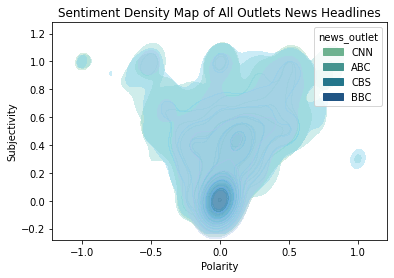

In [18]:
# Sentiment density plot
news_headlines_sample = news_headlines.sample(10000)
sentiment_density = sns.kdeplot(data=news_headlines_sample, x='name_sentiment', y='name_subjectivity', hue='news_outlet', fill=True, palette='crest', alpha=0.4)
sentiment_density.set(xlabel='Polarity', ylabel='Subjectivity', title='Sentiment Density Map of All Outlets News Headlines')
plt.show()

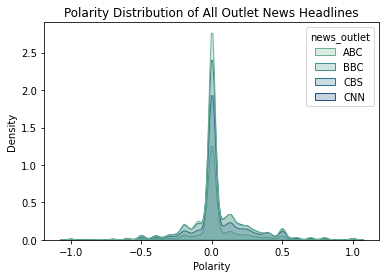

In [19]:
# Polarity Distribution
sentiment_distribution = sns.kdeplot(data=news_headlines, x='name_sentiment', hue='news_outlet', fill=True, palette='crest')
sentiment_distribution.set(xlabel='Polarity', title='Polarity Distribution of All Outlet News Headlines')
plt.show()

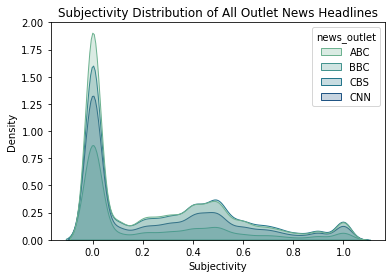

In [20]:
subjectivity_distribution = sns.kdeplot(data=news_headlines, x='name_subjectivity', hue='news_outlet', fill=True, palette='crest')
subjectivity_distribution.set(xlabel='Subjectivity', title='Subjectivity Distribution of All Outlet News Headlines')
plt.show()

In [21]:
# Get average of sentiment/subjectivity by news_outlet
news_outlet_avg_sentiment = news_headlines.groupby(by='news_outlet')[['name_sentiment', 'name_subjectivity']].mean()
print(news_outlet_avg_sentiment)

             name_sentiment  name_subjectivity
news_outlet                                   
ABC                0.040479           0.257900
BBC                0.037401           0.215839
CBS                0.036024           0.282539
CNN                0.046376           0.261577


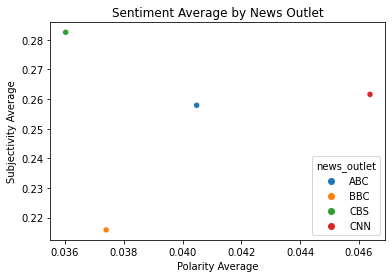

In [22]:
# Scatter plot of average sentiment by news_outlet
sentiment_avg_scatter = sns.scatterplot(data=news_outlet_avg_sentiment, x="name_sentiment", y="name_subjectivity", hue="news_outlet")
sentiment_avg_scatter.set(xlabel='Polarity Average', ylabel='Subjectivity Average', title='Sentiment Average by News Outlet')
plt.show()